In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

from src.hops import hops_rk_simple
from src.hops import hops_trotter_simple

In [47]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [48]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [1, 2, 4, 8, 1000]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

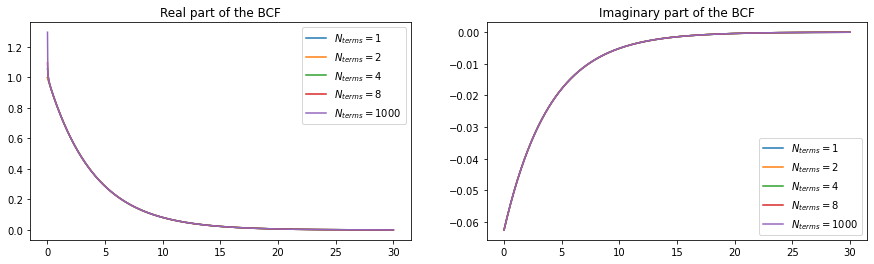

In [49]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend()
axarray[0].set_title("Real part of the BCF")
axarray[1].legend()
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

The BCF is sufficiently converged already at $N_\text{terms} = 1$! 

# HOMPS

In [50]:
N_terms = 1

In [51]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(1000, T, gamma, eta)

In [52]:
N_steps = 1000
N_trunc = 35 # starting from N_trunc = 39 this gets numerically instable ...
chimax = 10
epsilon = 0
N_krylov = 5

## temp: without compression

Without noise (RK):
took 2.6944637298583984 seconds


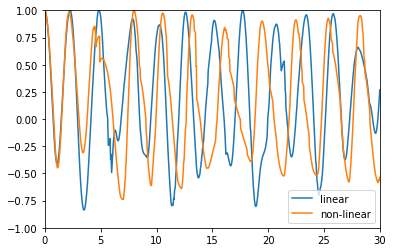

In [79]:
N_trunc = 40
N_steps = 1000
print("Without noise (RK):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()

print("took", end-start, "seconds")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

Without noise (RK):
took 2.3307929039001465 seconds


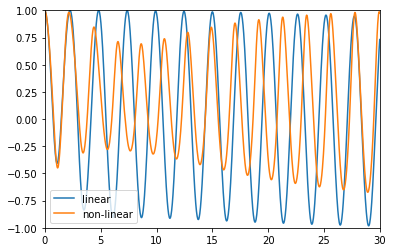

With noise (RK, non-linear):
took 6.47178053855896 seconds


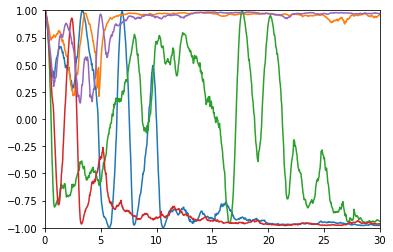

In [17]:
N_trunc = 35
N_steps = 1000
print("Without noise (RK):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()
print("took", end-start, "seconds")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

print("With noise (RK, non-linear):")
start = time.time()
for _ in range(5):
    hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4", noise_g=g_noise, noise_w=w_noise)
    psis = hierarchy.compute_realizations(1)
    sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
end = time.time()
print("took", end-start, "seconds")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

Without noise (RK):
took 2.299361228942871 seconds


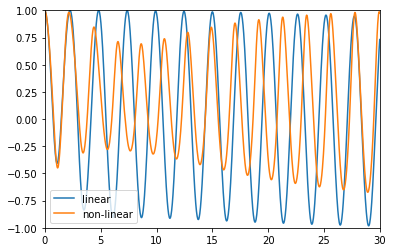

With noise (RK, non-linear):
took 6.226856231689453 seconds


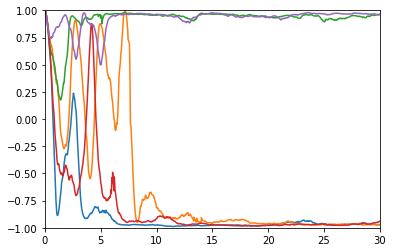

In [18]:
N_trunc = 35
N_steps = 1000
print("Without noise (RK):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()
print("took", end-start, "seconds")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

print("With noise (RK, non-linear):")
start = time.time()
for _ in range(5):
    hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
    psis = hierarchy.compute_realizations(1)
    sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
end = time.time()
print("took", end-start, "seconds")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

## temp: with compression

Without noise (RK):
took 3.8740718364715576 seconds


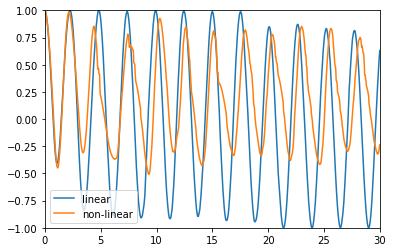

In [37]:
N_trunc = 38
print("Without noise (RK):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()

print("took", end-start, "seconds")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

Without noise (RK):
took 3.8532116413116455 seconds


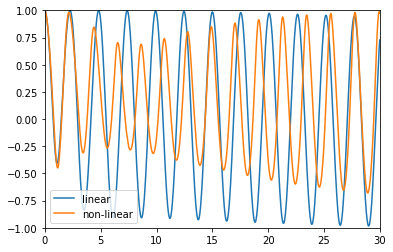

In [38]:
N_trunc = 35
print("Without noise (RK):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()

print("took", end-start, "seconds")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

Without noise (TDVP):
took 8.414704322814941 seconds


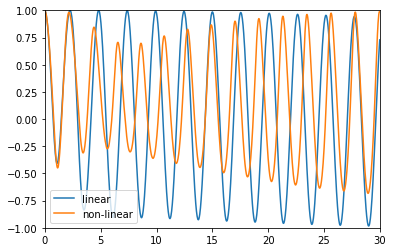

In [30]:
print("Without noise (TDVP):")
start = time.time()
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="TDVP")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="TDVP")
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()

print("took", end-start, "seconds")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

without noise (HOPS)
took 2.9479923248291016 seconds


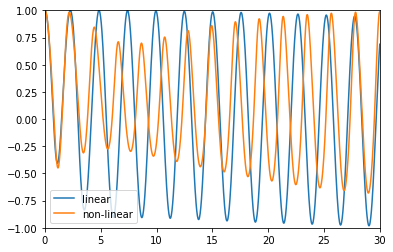

In [31]:
print("without noise (HOPS)")
start = time.time()
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, N_krylov=N_krylov)
psis = hops.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
psis = hops.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")
end = time.time()

print("took", end-start, "seconds")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

# Computing for different N_trunc

In [53]:
N_trunc = 35
N_krylov = 10

In [62]:
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method='TDVP')#, noise_g=g_noise, noise_w=w_noise)

In [63]:
psis_100_N_trunc_30 = hierarchy.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
#psis_1000_N_trunc_30 = hierarchy.compute_realizations(N_samples=1000, progressBar=tqdm)

In [66]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100_N_trunc_30, sigma_z)
#sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000_N_trunc_30, sigma_z)

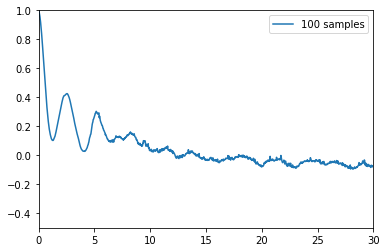

In [67]:
# not using g_noise and w_noise, TDVP
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

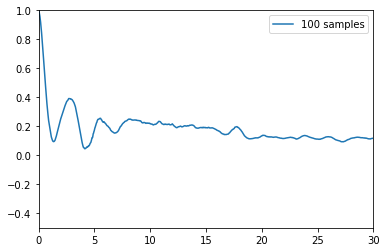

In [26]:
# using g_noise and w_noise
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

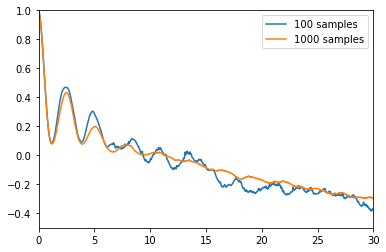

In [18]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

# Using Runge-Kutta HOPS (non-linear)

In [20]:
N_trunc = 35

In [20]:
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True)

In [21]:
psis_100 = hops.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
psis_1000 = hops.compute_realizations(N_samples=1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000, sigma_z)

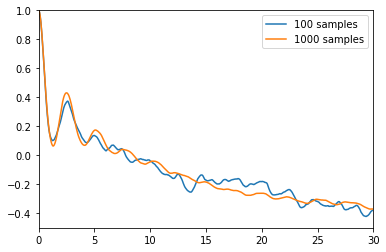

In [24]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

# Fine-tuned comparison (Linear)

In [68]:
N_steps = 1000
N_trunc = 30
chimax = 10
epsilon = 0
duration = 30
N_krylov = 5

In [70]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=True, N_krylov=N_krylov)
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)

In [71]:
zts = hops.generator.sample_process()

In [72]:
psis_hops = hops.compute_realizations(1, zts_debug=zts)
psis_homps = hierarchy.compute_realizations(1, zts_debug=zts, collect_debug_info=True)

In [73]:
sigma_zs_hops = compute_exp_val_linear(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val_linear(psis_homps, sigma_z)

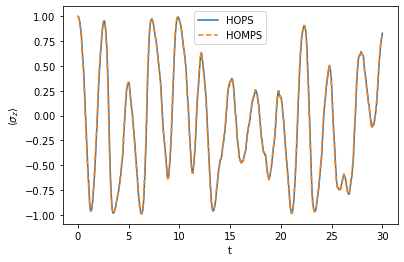

In [74]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()

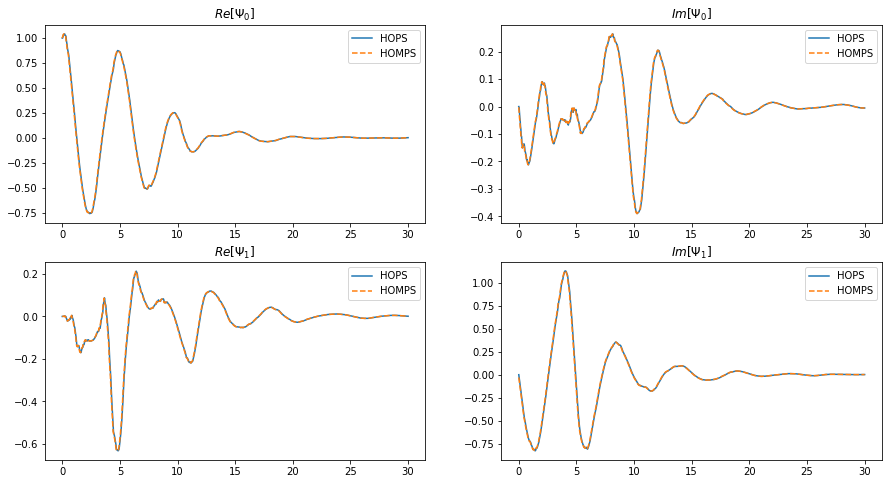

In [75]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

# Fine-tuned comparison (Non-Linear)

In [97]:
N_steps = 1000
N_trunc = 30
chimax = 10
epsilon = 0
duration = 30
N_krylov = 20

In [98]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True)
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)

In [99]:
zts = hops.generator.sample_process()

In [100]:
psis_hops = hops.compute_realizations(1, zts_debug=zts)
psis_homps = hierarchy.compute_realizations(1, zts_debug=zts, collect_debug_info=True)

In [101]:
sigma_zs_hops = compute_exp_val_nonlinear(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val_nonlinear(psis_homps, sigma_z)

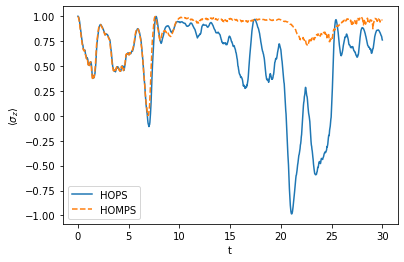

In [102]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.show()

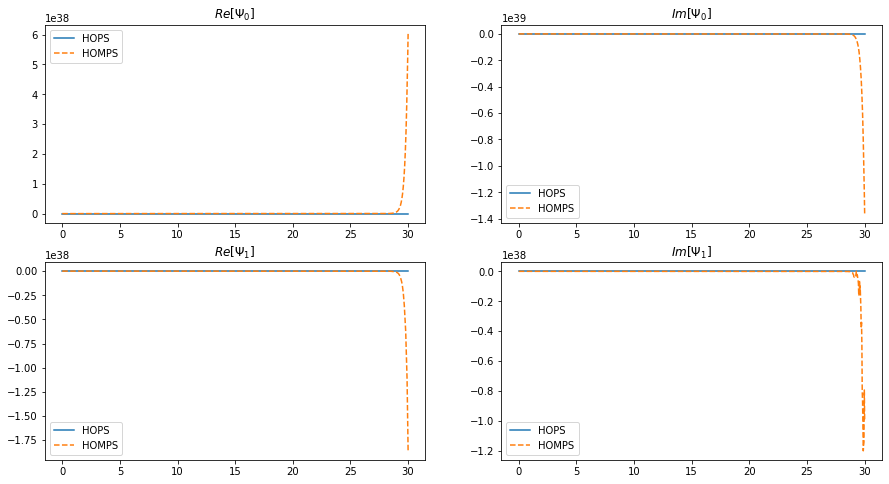

In [103]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

# Comparing MPOs

In [106]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False)
hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov)

In [107]:
# comparing MPO
mpo_hops = hops.Heff_linear.toarray()
hierarchy.model.update_mpo_linear(0)
W0 = hierarchy.model.H_mpo[0] # vL vR i i*
W1 = hierarchy.model.H_mpo[1] # vL vR j j*
left_contr = np.zeros(W0.shape[0])
left_contr[0] = 1.
right_contr = np.zeros(W1.shape[1])
right_contr[-1] = 1.
contr = np.tensordot(left_contr, W0, ([0], [0])) # -> vR i i*
contr = np.tensordot(contr, W1, ([0], [0])) # [vR] i i*; [vL] vR j j* -> i i* vR j j*
contr = np.tensordot(contr, right_contr, ([2], [0])) # -> i i* j j*
contr = np.transpose(contr, (2, 0, 3, 1)) # -> i j i* j*
contr = np.reshape(contr, (contr.shape[0]*contr.shape[1], contr.shape[2]*contr.shape[3]))
mpo_homps = contr

In [108]:
print(np.all((mpo_hops - mpo_homps) == 0))
print(np.sum(np.abs(mpo_hops - mpo_homps)))

True
0.0


The MPOs are identical ...